# Mining Process – % Silica Concentrate Prediction  

This project aims to develop a **machine learning regression model** to predict the **% Silica Concentrate** in a mining flotation process using operational plant data.  
Accurate prediction of silica concentration is essential to improve process efficiency, reduce laboratory dependency, and support real-time decision-making in the field. The code is divided into three main parts, which are:
1. Data ingestion and preprocessing  
2. Feature selection and treatment  
3. Time-aware train-test split  
4. Model training with early stopping  
5. Performance evaluation and result visualization  


**Responsible:** Paulo Casmal

**Email:** <paulo.casmal@gmail.com>

**Date:** 12-15-2025


---


## 01 - Imports & Configurations

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Configuration of matplotlib parameters for consistent styling
mpl.rcParams['figure.figsize'] = (10, 6)  # Default figure size
mpl.rc('lines', lw=2)  # Sets the line width
mpl.rcParams['grid.linewidth'] = 0.5  # Grid line width
mpl.rcParams['grid.linestyle'] = 'dashed'  # Grid line style
mpl.rc(('xtick', 'ytick'), labelsize=15)  # Axis tick label size
mpl.rc('font', family='Times New Roman', size=15)  # Font family and font size
mpl.rcParams['axes.linewidth'] = 0.5 # - Largura das bordas dos gráficos

In [3]:
# Load the dataset
path = r'C:\Users\paulo\Downloads\archive (2)\MiningProcess_Flotation_Plant_Database.csv'

df = pd.read_csv(path, decimal=',')

df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


## 02 - Dataset treatment

In [4]:
# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [5]:
df.columns

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

Drop the '% Iron Concentrate' column due to high correlation with target variable. Additionaly, this variable can be measured only at laboratory, which not helps to predict the '% Silica Concentrate' in field.

In [6]:
df = df.drop(columns=['% Iron Concentrate'])

### 02.1 - Adding Time Features

In [7]:


def create_time_features(df):
    """Create time-based features from datetime index."""
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter

    return df


df = create_time_features(df)

### 02.2 - Cross Validation

In [20]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=3*30*24*30, gap=3*30*24) # 15 days data for testing

df = df.sort_index()

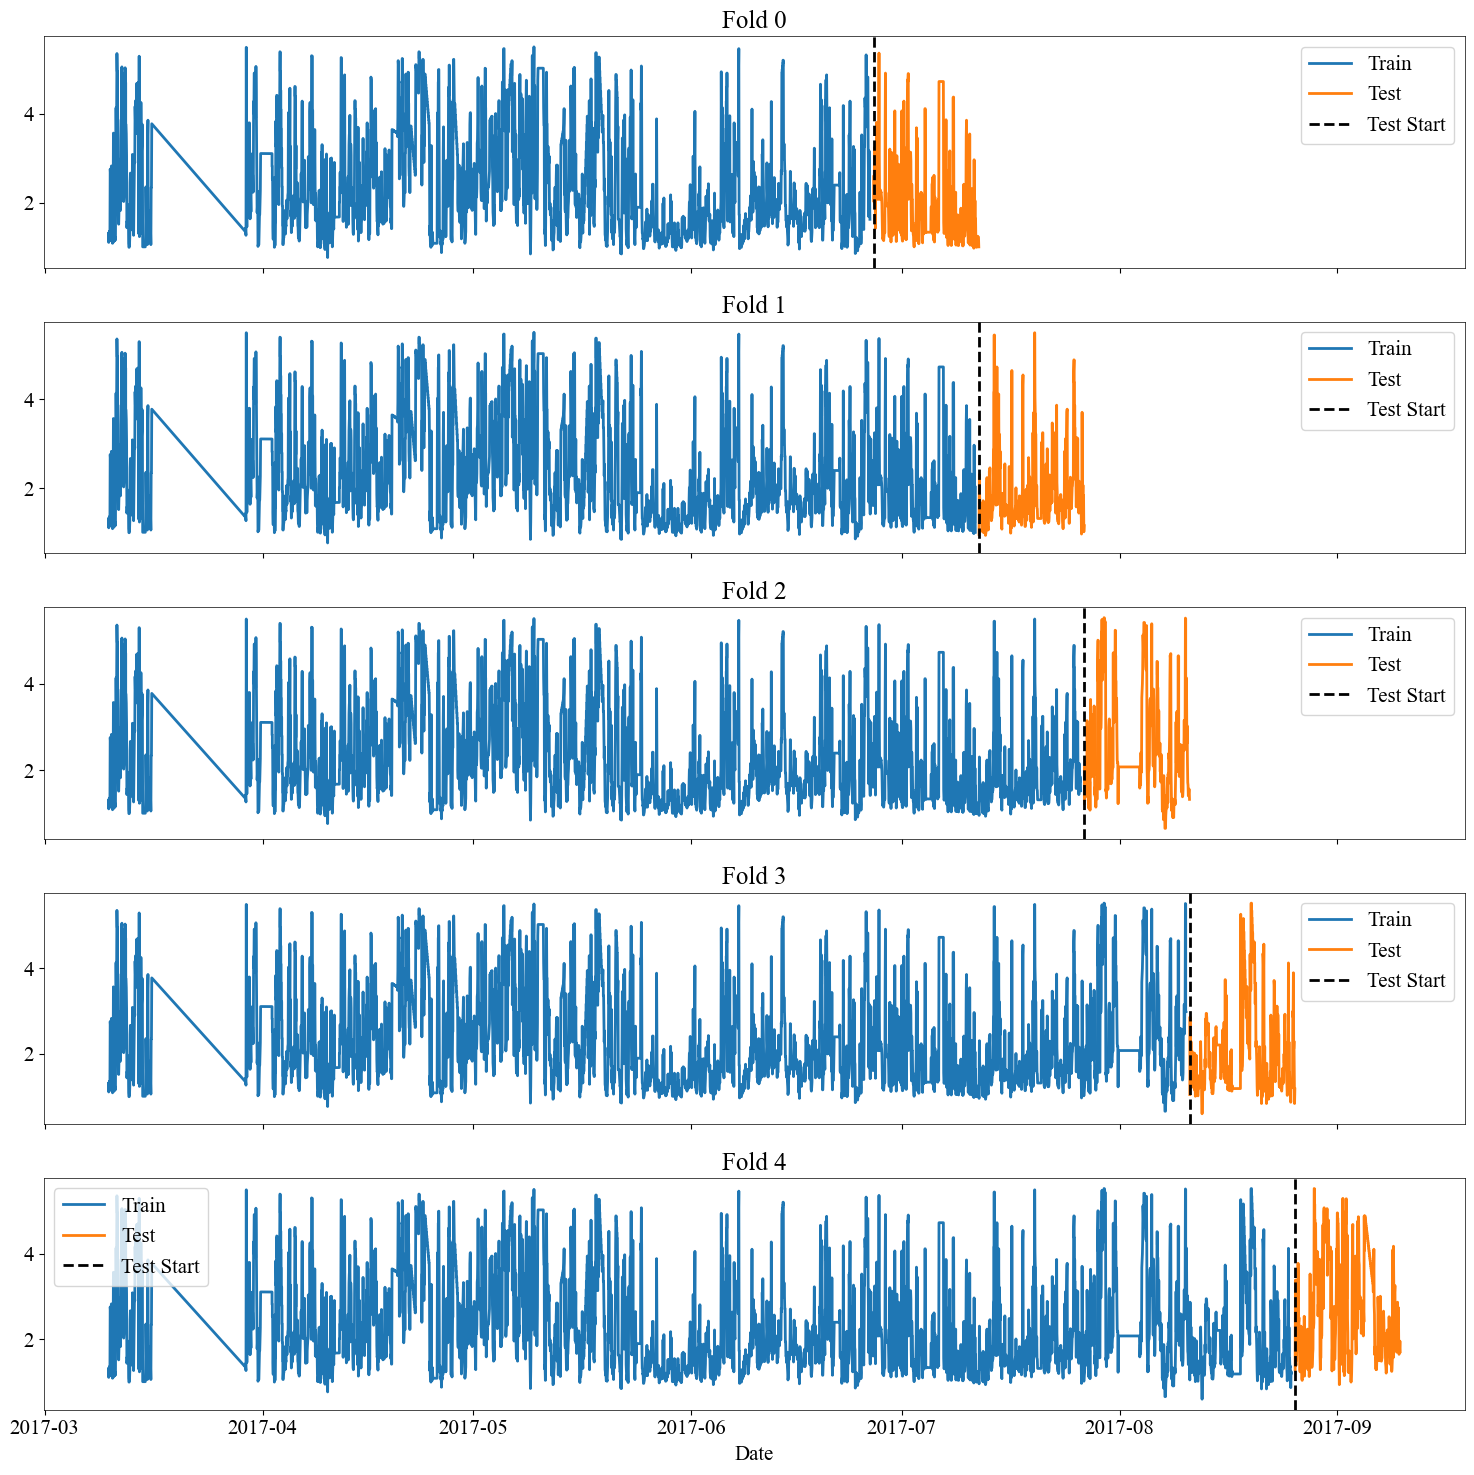

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_index, test_index) in enumerate(tss.split(df)):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    axs[fold].plot(train.index, train['% Silica Concentrate'], label='Train', color='tab:blue')
    axs[fold].plot(test.index, test['% Silica Concentrate'], label='Test', color='tab:orange')
    axs[fold].axvline(x=test.index[0], color='k', linestyle='--', label='Test Start')

    axs[fold].set_title(f'Fold {fold}')
    axs[fold].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### 02.3 - Lag Features

Lag features are not viable in this study case, since in field applications, the target variable is not available.

## 03 - Applying XGBoost Model

In [ ]:
# Split features and target variables
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Split features and target variable
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

X.shape, y.shape

((737453, 21), (737453, 1))

### New ***Train Test Split*** Method
Separating data by date instead traditional random separation.

In [ ]:
# Split the data into training and testing sets based on date
X_train = X[X.index < '2017-08-01 00:00:00']
X_test = X[X.index > '2017-08-01 00:00:00']
y_train = y[y.index < '2017-08-01 00:00:00']
y_test = y[y.index > '2017-08-01 00:00:00']

In [ ]:
# Train the XGBoost regressor with early stopping
reg = xgb.XGBRegressor(
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.001,
                       objective='reg:squarederror',
                       random_state=42,
                       verbose=50
                       )

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:1.12205	validation_1-rmse:1.13636
[50]	validation_0-rmse:1.10558	validation_1-rmse:1.13335
[100]	validation_0-rmse:1.08990	validation_1-rmse:1.13123
[150]	validation_0-rmse:1.07520	validation_1-rmse:1.12953
[200]	validation_0-rmse:1.06141	validation_1-rmse:1.12873
[250]	validation_0-rmse:1.04859	validation_1-rmse:1.12816
[300]	validation_0-rmse:1.03652	validation_1-rmse:1.12782
[350]	validation_0-rmse:1.02518	validation_1-rmse:1.12730
[400]	validation_0-rmse:1.01458	validation_1-rmse:1.12697
[450]	validation_0-rmse:1.00466	validation_1-rmse:1.12687
[481]	validation_0-rmse:0.99858	validation_1-rmse:1.12691


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 04 - Result Analysis

In [ ]:
# Make predictions and evaluate the model
y_pred = reg.predict(X_test)

print(mean_squared_error(y_test, y_pred))

1.2697430450890814


In [30]:
results = reg.evals_result_
print(results.keys())

dict_keys(['validation_0', 'validation_1'])


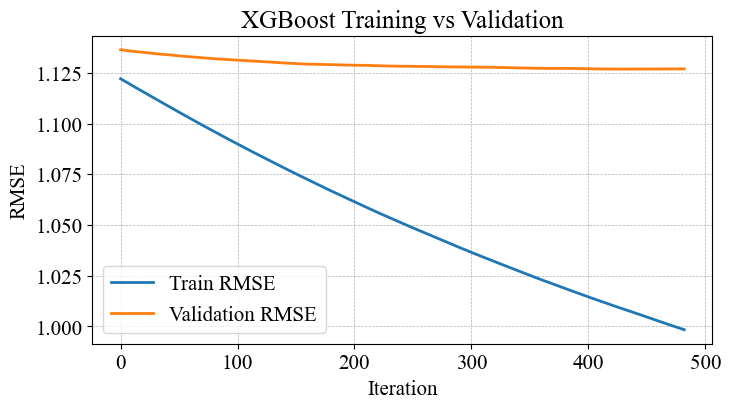

In [ ]:
train_rmse = results['validation_0']['rmse']
val_rmse   = results['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('XGBoost Training vs Validation')
plt.legend()

# plt.yscale('log')
plt.grid(True)
plt.show()


In [44]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.8796025542631704


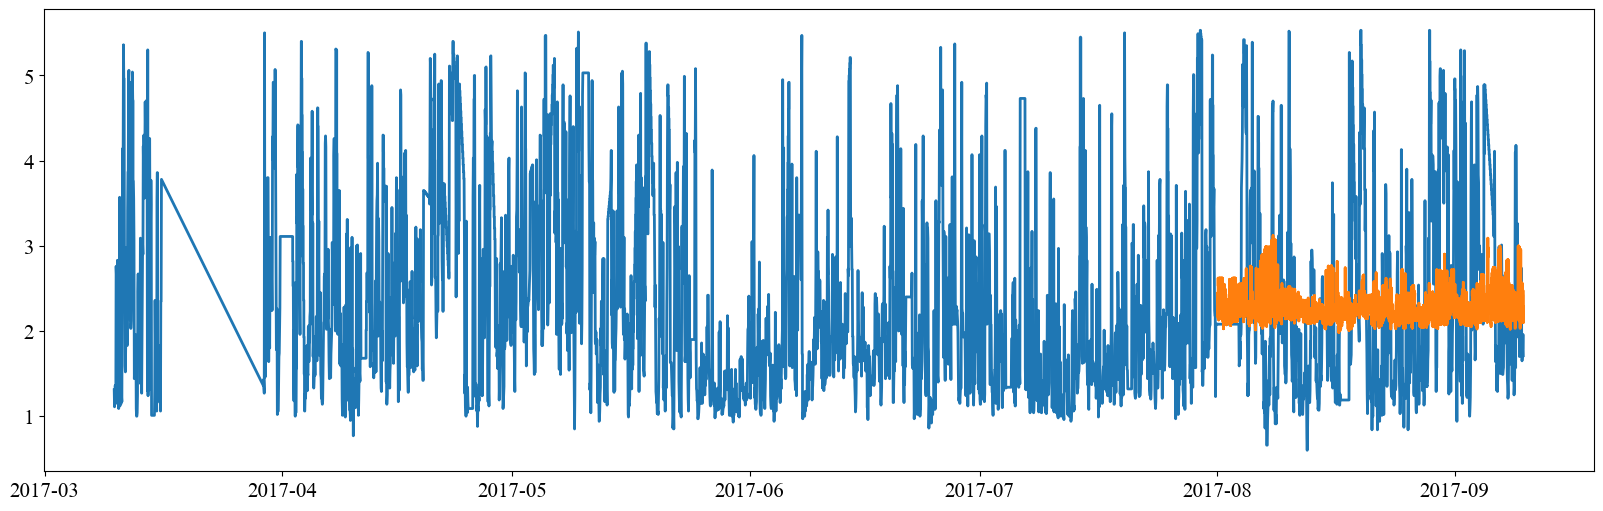

In [36]:
plt.figure(figsize=(20, 6))

plt.plot(y_train.index, y_train['% Silica Concentrate'], label='Actual % Silica Concentrate', c='tab:blue')
plt.plot(y_test.index, y_test['% Silica Concentrate'], label='Actual % Silica Concentrate', c='tab:blue')

plt.plot(y_test.index, y_pred, label='Predicted % Silica Concentrate', c='tab:orange')  

plt.show()

In [42]:
yy = df[df.index > '2017-08-01 00:00:00']

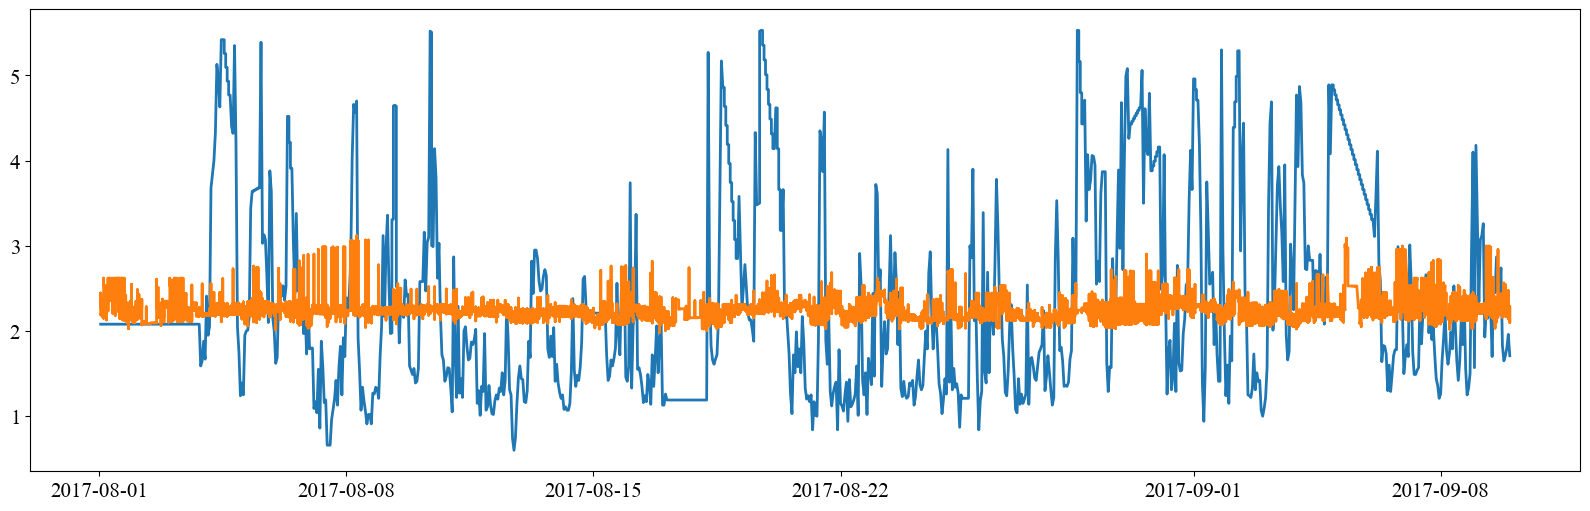

In [43]:
plt.figure(figsize=(20, 6))

plt.plot(yy.index, yy['% Silica Concentrate'], label='Actual % Silica Concentrate', c='tab:blue')

plt.plot(y_test.index, y_pred, label='Predicted % Silica Concentrate', c='tab:orange')  

plt.show()